In [1]:
import itertools
import collections
import copy
import os
import pickle
import warnings
import adjustText

from functools import reduce

import matplotlib.pyplot as plt
import matplotlib
import statsmodels
import statsmodels.api
import statsmodels.formula.api
import matplotlib_venn
import pandas
import cooltools
import cooler
import seaborn
import numpy
import scipy
import h5py
import sklearn

In [2]:
cmap = "magma_r"
# cmap = "pink_r"
tri_palette = ["#32D9CE", "#DBC977", "#E856D1"]
small_palette = ["#c845aa", "#65cbbe", "#d6c95f", "#acacac"]
palette = ["#56b4e9","#e9566b", "#e9d556", "#00d198", "#eca1d5", "#185a88", "#9fa0a0"]
palette_expanded = ["#56b4e9","#e9566b", "#e9d556", "#00d198", "#eca1d5", "#185a88", "#9fa0a0", "#733b14"]
palette_cmap = matplotlib.colors.ListedColormap(palette)
plt.register_cmap(name="my_palette", cmap=palette_cmap)


# Setup.
cm = matplotlib.cm.coolwarm
cdict = {"red":[], "green": [], "blue": [], "alpha": []}

# Get top range of coolwarm and interpolate between.
for i in range(127, 256):
    r, g, b, a = cm(i)
    si = ((i - 127) * 2) / 256
    cdict["red"].append((si, r, r))
    cdict["green"].append((si, g, g))
    cdict["blue"].append((si, b, b))
    cdict["alpha"].append((si, a, a))
warm = matplotlib.colors.LinearSegmentedColormap("warm", cdict)
plt.register_cmap(cmap=warm)
    

In [3]:
def reset_plot_config():
    seaborn.set()
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    
    d = {
        "ytick.major.width": 0.4,
        "ytick.minor.width": 0.4,
        "xtick.major.width": 0.4,
        "xtick.minor.width": 0.4,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "ytick.minor.size": 1.6,
        "xtick.minor.size": 1.6}

    for k, v in d.items():
        matplotlib.rcParams[k] = v
        
    matplotlib.rcParams['xtick.major.pad'] = 2
    matplotlib.rcParams['ytick.major.pad'] = 2
    matplotlib.rcParams["figure.dpi"] = 200
    matplotlib.rcParams["axes.facecolor"] = "w"
    matplotlib.rcParams["figure.facecolor"] = "w"
    matplotlib.rcParams["xtick.labelsize"] = 12
    matplotlib.rcParams["ytick.labelsize"] = 12
    matplotlib.rcParams["axes.labelsize"] = 12
    matplotlib.rcParams['axes.titlesize'] = 13
    matplotlib.rcParams['legend.fontsize'] = 12
    matplotlib.rcParams['axes.titlepad'] = 8
#     matplotlib.rcParams["axes.edgecolor"] = "light_gray"
#     matplotlib.rcParams["axes.linewidth"] = 1.25
    
#     matplotlib.rcParams['axes.ymargin'] = 0
#     matplotlib.rcParams['axes.xmargin'] = 0
    for x in ["left", "right", "top", "bottom"]:
        matplotlib.rcParams["figure.subplot.{}".format(x)] = 0.08 if x in {"left",  "bottom"} else 0.99

    matplotlib.rcParams["legend.fancybox"] = False

    # Legend settings:    
    d = {"legend.borderpad" : 0.4,  
        "legend.labelspacing" : 0.0,  
        "legend.handlelength" : 2.0,  
        "legend.handleheight" : 0.7,
        "legend.handletextpad" : 0.,
        "legend.borderaxespad" : 0.5,
        "legend.fontsize": 12,
        "legend.borderpad": 0.4}

    #legend.columnspacing}
    for k, v in d.items():
        matplotlib.rcParams[k] = v
        
reset_plot_config()

# Load insulation scores

In [53]:
stages = ["nc1-8_1_1+1_2+2_1+2_2",
          "nc14_1_1+1_2+2_1+2_2",
          "s10-12_1_1+1_2+2_1+2_2",
          "nc12_mitotic_FED_all_1_1+1_2",
          "nc14_FED_all_1_1+1_2",
          "nc1-8_PCNA_1+PCNA_2+PCNA_3",
          "ogiyama_et_al_nc1-8",
          "ogiyama_et_al_nc9-13",
          "ogiyama_et_al_nc13early", 
          "ogiyama_et_al_nc14late",
          "ogiyama_et_al_s16"]
chroms = ["2L", "2R", "3L", "3R", "4", "X", "Y"]

In [54]:
val_dict = dict()
for cur_stage in stages:
    f = '/Genomics/function/ogtgrid/ecofer/drosophila_micro_c/4DN_data/merged_boundaries'
    f = os.path.join(f, "{}.base_resolution=100.resolution=400.window_size=16.main_chroms_merged.h5".format(cur_stage))
    h5 = h5py.File(f, "r")
    cur_x = list()
    for cur_chrom in chroms:
        cur_x.append(h5[cur_chrom]["1b"]['Original'][()])
#         cur_x.append(h5[cur_chrom]["1k"]['amean'][()])
    val_dict[cur_stage] = numpy.concatenate(cur_x)
    h5.close()
    print("Finished", cur_stage, flush=True)

Finished nc1-8_1_1+1_2+2_1+2_2
Finished nc14_1_1+1_2+2_1+2_2
Finished s10-12_1_1+1_2+2_1+2_2
Finished nc12_mitotic_FED_all_1_1+1_2
Finished nc14_FED_all_1_1+1_2
Finished nc1-8_PCNA_1+PCNA_2+PCNA_3
Finished ogiyama_et_al_nc1-8
Finished ogiyama_et_al_nc9-13
Finished ogiyama_et_al_nc13early
Finished ogiyama_et_al_nc14late
Finished ogiyama_et_al_s16


In [57]:
numpy.random.seed(1337)

# Get valid idx.
valid = None
for x in val_dict.keys():
    xv = val_dict[x].copy()
    if valid is None:
        valid = numpy.isfinite(xv) & ~numpy.isnan(xv)
    else:
        valid = valid & (numpy.isfinite(xv) & ~numpy.isnan(xv))
valid_val_dict = dict()
for x in val_dict.keys():
    valid_val_dict[x] = val_dict[x][valid].copy()
        
        
# Get corr.
cor_df = list()
idx = numpy.random.choice(valid_val_dict["nc1-8_1_1+1_2+2_1+2_2"].shape[0], size=10_000_000)
for x in stages:
    for y in stages:
        print("On", x, y, flush=True)
        xv = valid_val_dict[x][idx]
        yv = valid_val_dict[y][idx]
        sp = scipy.stats.spearmanr(xv, yv)[0]
        pr = scipy.stats.pearsonr(xv, yv)[0]
        cor_df.append((x, y, sp, pr))
cor_df = pandas.DataFrame(cor_df, columns=["from", "to", "spearmanr", "pearsonr"])

rename = {
          "nc1-8_1_1+1_2+2_1+2_2": "nc1-8",
          "nc14_1_1+1_2+2_1+2_2": "nc14",
          "s10-12_1_1+1_2+2_1+2_2": "s10-12",
          "nc12_mitotic_FED_all_1_1+1_2": "n12M",
          "nc14_FED_all_1_1+1_2": "nc14 (v2)",
          "nc1-8_PCNA_1+PCNA_2+PCNA_3": "nc1-8 (PCNA)",
          "ogiyama_et_al_nc1-8": "nc1-8 (Ogiyama et al. 2018)",
          "ogiyama_et_al_nc9-13": "nc9-13 (Ogiyama et al. 2018)",
          "ogiyama_et_al_nc13early": "nc14E (Ogiyama et al. 2018)", 
          "ogiyama_et_al_nc14late": "nc14L (Ogiyama et al. 2018)",
          "ogiyama_et_al_s16": "s16 (Ogiyama et al. 2018)"

}
cor_df["from"] = cor_df["from"].apply(lambda x: rename[x])
cor_df["to"] = cor_df["to"].apply(lambda x: rename[x])
cor_df

On nc1-8_1_1+1_2+2_1+2_2 nc1-8_1_1+1_2+2_1+2_2
On nc1-8_1_1+1_2+2_1+2_2 nc14_1_1+1_2+2_1+2_2
On nc1-8_1_1+1_2+2_1+2_2 s10-12_1_1+1_2+2_1+2_2
On nc1-8_1_1+1_2+2_1+2_2 nc12_mitotic_FED_all_1_1+1_2
On nc1-8_1_1+1_2+2_1+2_2 nc14_FED_all_1_1+1_2
On nc1-8_1_1+1_2+2_1+2_2 nc1-8_PCNA_1+PCNA_2+PCNA_3
On nc1-8_1_1+1_2+2_1+2_2 ogiyama_et_al_nc1-8
On nc1-8_1_1+1_2+2_1+2_2 ogiyama_et_al_nc9-13
On nc1-8_1_1+1_2+2_1+2_2 ogiyama_et_al_nc13early
On nc1-8_1_1+1_2+2_1+2_2 ogiyama_et_al_nc14late
On nc1-8_1_1+1_2+2_1+2_2 ogiyama_et_al_s16
On nc14_1_1+1_2+2_1+2_2 nc1-8_1_1+1_2+2_1+2_2
On nc14_1_1+1_2+2_1+2_2 nc14_1_1+1_2+2_1+2_2
On nc14_1_1+1_2+2_1+2_2 s10-12_1_1+1_2+2_1+2_2
On nc14_1_1+1_2+2_1+2_2 nc12_mitotic_FED_all_1_1+1_2
On nc14_1_1+1_2+2_1+2_2 nc14_FED_all_1_1+1_2
On nc14_1_1+1_2+2_1+2_2 nc1-8_PCNA_1+PCNA_2+PCNA_3
On nc14_1_1+1_2+2_1+2_2 ogiyama_et_al_nc1-8
On nc14_1_1+1_2+2_1+2_2 ogiyama_et_al_nc9-13
On nc14_1_1+1_2+2_1+2_2 ogiyama_et_al_nc13early
On nc14_1_1+1_2+2_1+2_2 ogiyama_et_al_nc14late
On nc

from                            to  spearmanr  \
0                        nc1-8                         nc1-8   1.000000   
1                        nc1-8                          nc14   0.751863   
2                        nc1-8                        s10-12   0.760424   
3                        nc1-8                          n12M   0.663394   
4                        nc1-8                     nc14 (v2)   0.724390   
..                         ...                           ...        ...   
116  s16 (Ogiyama et al. 2018)   nc1-8 (Ogiyama et al. 2018)   0.664816   
117  s16 (Ogiyama et al. 2018)  nc9-13 (Ogiyama et al. 2018)   0.752751   
118  s16 (Ogiyama et al. 2018)   nc13E (Ogiyama et al. 2018)   0.869970   
119  s16 (Ogiyama et al. 2018)   nc14L (Ogiyama et al. 2018)   0.888144   
120  s16 (Ogiyama et al. 2018)     s16 (Ogiyama et al. 2018)   1.000000   

     pearsonr  
0    1.000000  
1    0.675002  
2    0.691083  
3    0.593686  
4    0.622829  
..        ...  
116  0.748844  
117  0.820112  
118  0.885714  
119  0.896646  
120  1.000000  

[121 rows x 4 columns]

In [65]:
idx.shape

(1000000,)

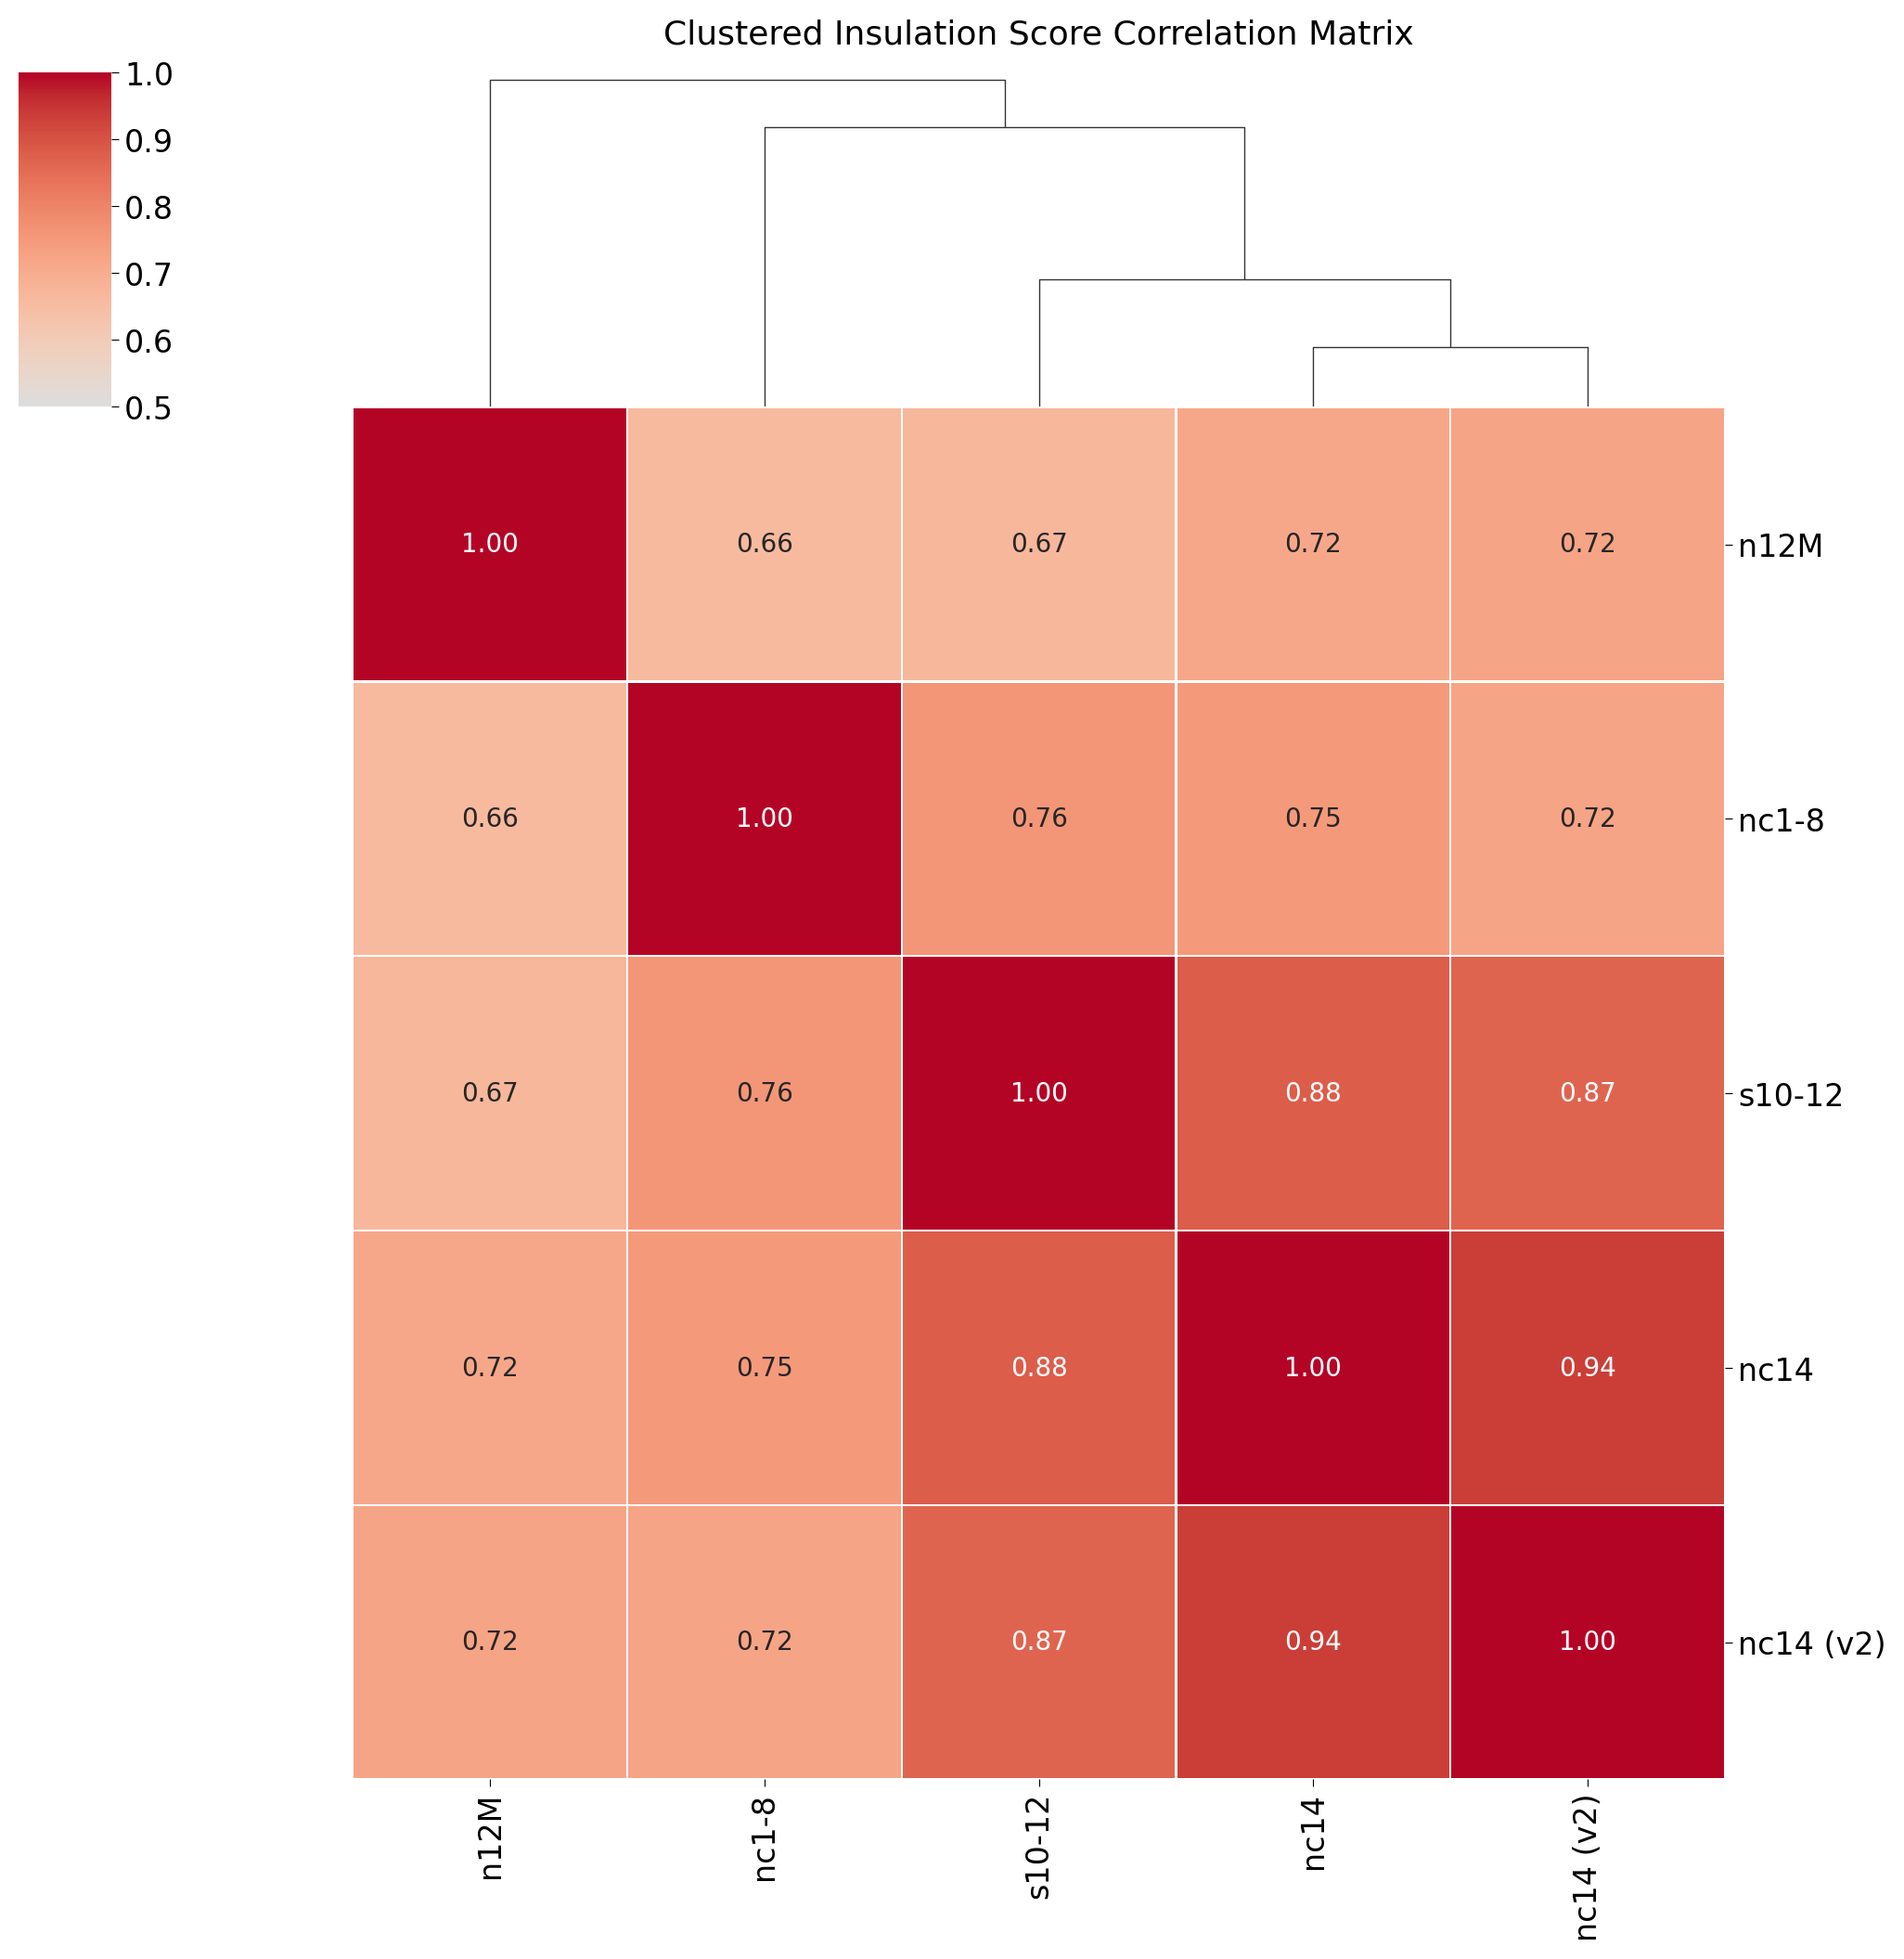

In [64]:
tmp = cor_df.copy()
tmp = tmp[tmp["from"].apply(lambda x: "Ogiyama" not in x and "PCNA" not in x).values]
tmp = tmp[tmp['to'].apply(lambda x: "Ogiyama" not in x and "PCNA" not in x).values]
spearman_df = tmp.pivot_table(columns='from', index='to', values="spearmanr")
df = spearman_df.copy()
# for i in range(df.shape[0]):
#     for j in range(i + 1, df.shape[0]):
#         if numpy.isnan(df.iloc[(i, j)]):
#             df.iloc[(i, j)] = df.iloc[(j, i)]
#         else:
#             df.iloc[(j, i)] = df.iloc[(i, j)]


hm = seaborn.clustermap(spearman_df, 
                        metric='euclidean', method='complete',
                        cmap="warm", 
                        annot=True, fmt='.2f',
                        xticklabels=1, yticklabels=1, vmin=0.5, vmax=1, #vmin=0, vmax=1,
                        figsize=(10, 10),
                        lw=0.5)

# hm.ax_row_dendrogram.set_visible(False)
hm.ax_heatmap.set(xlabel="", ylabel="")
hm.ax_col_dendrogram.set(title="Clustered Insulation Score Correlation Matrix")
plt.setp(hm.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(hm.ax_heatmap.get_xticklabels(), rotation=90)
hm.ax_heatmap.set_xlabel("")
hm.ax_heatmap.set_ylabel(None)
hm.ax_row_dendrogram.set_visible(False)
# plt.savefig("/flash/ecofer/drosophila_micro_c/figures/insulation_score_correlation_matrix.svg", format="svg")
plt.show()


In [ ]:
1

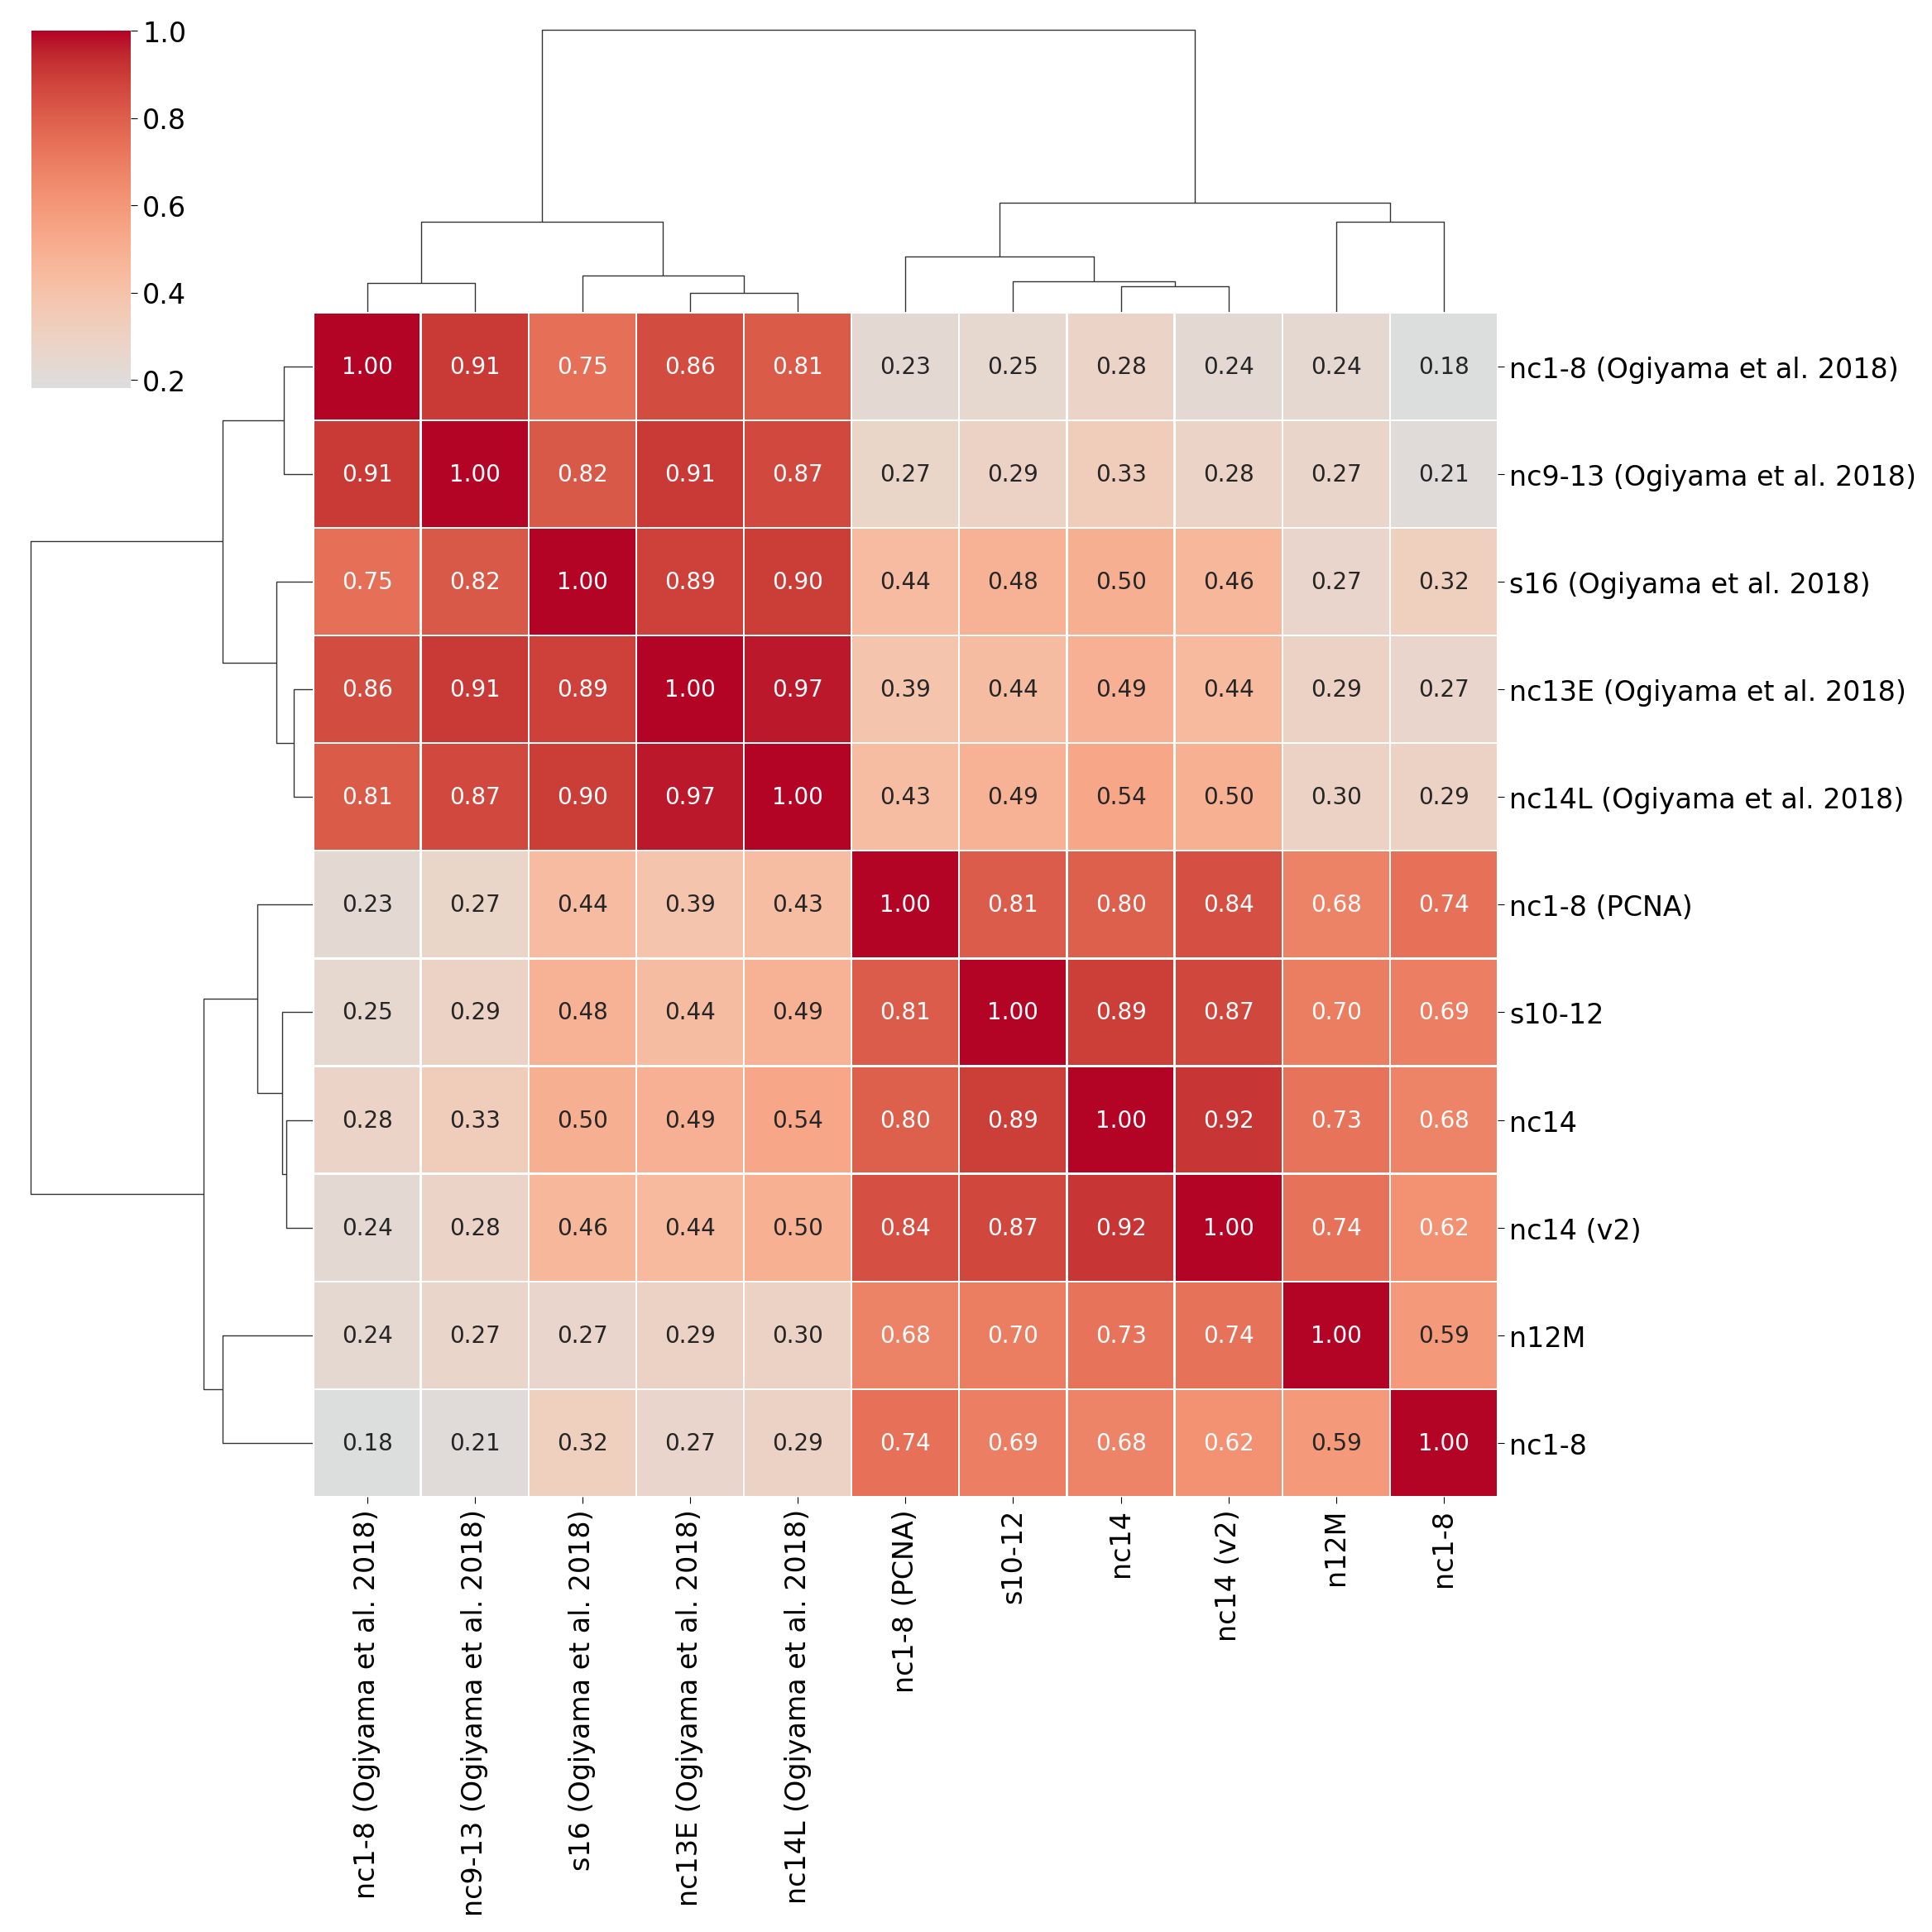

In [59]:
pearson_df = cor_df.pivot_table(columns='from', index='to', values="pearsonr")
hm = seaborn.clustermap(pearson_df, cmap="warm", xticklabels=1, metric='euclidean', method='complete',
                        yticklabels=1, figsize=(12, 12), annot=True, lw=0.5, fmt=".2f")# fmt=".3g",)
hm.ax_heatmap.set(xlabel="", ylabel="")
# plt.savefig("/flash/ecofer/drosophila_micro_c/figures/insulation_score_correlation_matrix.svg", format="svg")
plt.show()